# Automated Monte Carlo Simulations

In [1]:
# importing libraries

import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm, gmean, cauchy
import seaborn as sns
from datetime import datetime

In [2]:
def import_stock_data(tickers, start = '2010-1-1', end = datetime.today().strftime('%Y-%m-%d')):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

In [3]:
data = import_stock_data(['JPM'])

In [4]:
def log_returns(data):
    return (np.log(1+data.pct_change()))

log_return = log_returns(data)

def simple_returns(data):
    return ((data/data.shift(1))-1)

# CAPM 

In [5]:
def market_data_combination(data, mark_ticker = "^GSPC", start='2010-1-1'):
    market_data = import_stock_data(mark_ticker, start)
    market_rets = log_returns(market_data).dropna()
    ann_return = np.exp(market_rets.mean()*252).values-1
    data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return

def beta_sharpe(data, mark_ticker = "^GSPC", start='2010-1-1', riskfree = 0.025):
     # Beta
    dd, mark_ret = market_data_combination(data, mark_ticker, start)
    log_ret = log_returns(dd)
    covar = log_ret.cov()*252
    covar = pd.DataFrame(covar.iloc[:-1,-1])
    mrk_var = log_ret.iloc[:,-1].var()*252
    beta = covar/mrk_var
    
    stdev_ret = pd.DataFrame(((log_ret.std()*250**0.5)[:-1]), columns=['STD'])
    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    # CAPM
    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row[mark_ticker] * (mark_ret-riskfree))
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-riskfree)/(row['STD']))
    beta.rename(columns={"^GSPC":"Beta"}, inplace=True)
    
    return beta

In [6]:
beta_sharpe(data)

,Beta,STD,CAPM,Sharpe
JPM,1.293722,0.288814,0.14155,0.403548


# Brownian motion

In [8]:
def drift_calc(data, return_type='log'):
    if return_type=='log':
        lr = log_returns(data)
    elif return_type=='simple':
        lr = simple_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(0.5*var)
    try:
        return drift.values
    except:
        return drift
    
drift_calc(data)

array([0.00032233])

In [9]:
def daily_returns(data, days, iterations, return_type='log'):
    ft = drift_calc(data, return_type)
    if return_type == 'log':
        try:
            stv = log_returns(data).std().values
        except:
            stv = log_returns(data).std()
    elif return_type=='simple':
        try:
            stv = simple_returns(data).std().values
        except:
            stv = simple_returns(data).std()    
    #Oftentimes, we find that the distribution of returns is a variation of the normal distribution where it has a fat tail
    # This distribution is called cauchy distribution
    dr = np.exp(ft + stv * norm.ppf(np.random.rand(days, iterations)))
    return dr

In [10]:
dr = daily_returns(data, 2, 3)

In [13]:
def probs_find(predicted, higherthan, on = 'value'):
    
    if on == 'return':
        predicted0 = predicted.iloc[0,0]
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 >= higherthan]
        less = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 < higherthan]
    elif on == 'value':
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [i for i in predList if i >= higherthan]
        less = [i for i in predList if i < higherthan]
    else:
        print("'on' must be either value or return")
    return (len(over)/(len(over)+len(less)))

In [14]:
def simulate_mc(data, days, iterations, return_type='log', plot=True):
    # Generate daily returns
    returns = daily_returns(data, days, iterations, return_type)
    # Create empty matrix
    price_list = np.zeros_like(returns)
    # Put the last actual price in the first row of matrix. 
    price_list[0] = data.iloc[-1]
    # Calculate the price of each day
    for t in range(1,days):
        price_list[t] = price_list[t-1]*returns[t]
    
    # Plot Option
    if plot == True:
        x = pd.DataFrame(price_list).iloc[-1]
        fig, ax = plt.subplots(1,2, figsize=(14,4))
        sns.distplot(x, ax=ax[0])
        sns.distplot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
        plt.xlabel("Stock Price")
        plt.show()
    
    #CAPM and Sharpe Ratio
    
    # Printing information about stock
    try:
        [print(nam) for nam in data.columns]
    except:
        print(data.name)
    print(f"Days: {days-1}")
    print(f"Expected Value: ${round(pd.DataFrame(price_list).iloc[-1].mean(),2)}")
    print(f"Return: {round(100*(pd.DataFrame(price_list).iloc[-1].mean()-price_list[0,1])/pd.DataFrame(price_list).iloc[-1].mean(),2)}%")
    print(f"Probability of Breakeven: {probs_find(pd.DataFrame(price_list),0, on='return')}")
   
          
    return pd.DataFrame(price_list)

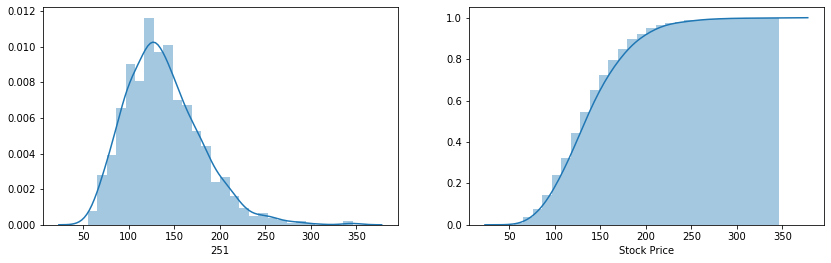

JPM
Days: 251
Expected Value: $138.25
Return: 12.65%
Probability of Breakeven: 0.641


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,120.760002,120.760002,120.760002,120.760002,120.760002,120.760002,120.760002,120.760002,120.760002,120.760002,...,120.760002,120.760002,120.760002,120.760002,120.760002,120.760002,120.760002,120.760002,120.760002,120.760002
1,118.395848,118.375928,122.871809,122.204404,122.484980,123.941107,121.188034,121.386382,123.359111,123.143100,...,121.726135,122.514629,121.839173,119.023621,123.660515,126.081301,119.845635,121.312915,121.570946,121.469877
2,114.977140,117.590177,118.783380,126.467009,120.264747,124.264452,119.140369,123.259461,125.737175,123.735204,...,119.775281,121.759255,119.171520,117.596955,120.716026,126.483803,116.353015,123.245133,120.296403,122.062523
3,113.371901,117.703212,118.203552,124.182101,121.328933,120.331208,117.962788,122.939789,125.352944,122.012572,...,123.514310,122.189228,120.502145,118.451484,120.465874,123.557449,116.678762,122.452645,120.455299,120.883041
4,114.714876,116.060132,118.780212,126.180284,119.642031,118.300350,121.430970,125.253762,124.278537,124.692872,...,123.253129,120.467566,115.146797,120.083117,123.720302,129.118849,119.950559,121.044477,119.130344,117.034549
5,111.645065,113.781241,118.981527,125.729680,120.733865,118.402697,121.950550,128.982496,122.428999,123.586271,...,122.941472,122.024388,116.437692,123.127591,121.904255,133.827456,124.020692,123.667251,118.871796,114.808723
6,114.200247,114.925980,120.312972,122.489485,120.782910,118.000490,123.197272,127.972488,122.092017,126.530162,...,119.356375,122.156138,113.085813,128.539585,122.303651,133.255198,125.101040,129.335202,119.677486,113.504122
7,113.354634,112.723739,117.888278,119.055577,121.534417,119.660444,124.783165,129.377239,119.720606,130.269513,...,118.350488,120.330802,114.586669,129.690390,122.984677,137.047454,125.326867,129.081969,119.770245,112.282546
8,114.004810,110.923212,117.952999,116.343084,121.028736,117.795728,123.087961,127.584930,121.587455,129.539715,...,119.409978,116.875668,115.991360,128.196939,125.171490,135.512544,126.539545,128.753690,124.787111,111.211681
9,112.800515,109.648467,120.302990,117.318497,117.467024,115.242172,122.207864,130.186813,122.558342,133.622851,...,120.907001,118.761812,115.326252,128.657906,123.982658,135.248472,126.845840,132.430177,126.203541,111.381686


In [15]:
simulate_mc(data, 252, 1000, 'log')

# Final run

In [16]:
def monte_carlo(tickers, days_forecast, iterations, start_date = '2000-1-1', return_type = 'log', plotten=False):
    data = import_stock_data(tickers, start=start_date)
    inform = beta_sharpe(data, mark_ticker="^GSPC", start=start_date)
    simulatedDF = []
    for t in range(len(tickers)):
        y = simulate_mc(data.iloc[:,t], (days_forecast+1), iterations, return_type)
        if plotten == True:
            forplot = y.iloc[:,0:10]
            forplot.plot(figsize=(15,4))
        print(f"Beta: {round(inform.iloc[t,inform.columns.get_loc('Beta')],2)}")
        print(f"Sharpe: {round(inform.iloc[t,inform.columns.get_loc('Sharpe')],2)}") 
        print(f"CAPM Return: {round(100*inform.iloc[t,inform.columns.get_loc('CAPM')],2)}%")
        y['ticker'] = tickers[t]
        cols = y.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        y = y[cols]
        simulatedDF.append(y)
    simulatedDF = pd.concat(simulatedDF)
    return simulatedDF

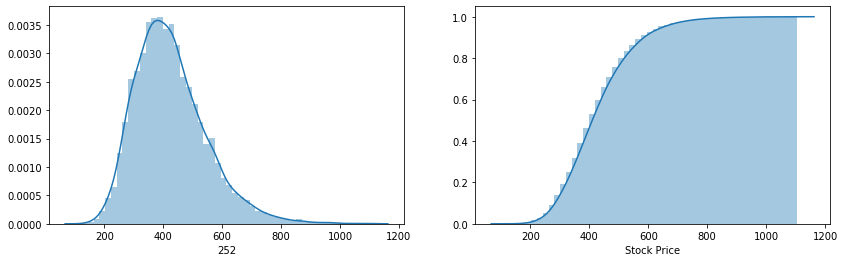

V
Days: 252
Expected Value: $425.29
Return: 20.98%
Probability of Breakeven: 0.7617
Beta: 1.23
Sharpe: 0.34
CAPM Return: 11.96%


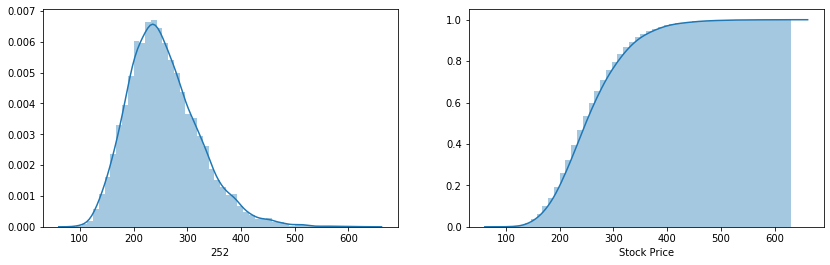

MA
Days: 252
Expected Value: $256.47
Return: 18.38%
Probability of Breakeven: 0.7505
Beta: 1.13
Sharpe: 0.34
CAPM Return: 11.2%


In [18]:
start = "2015-1-1"
days_to_forecast= 252
simulation_trials= 10000
ret_sim_df = monte_carlo(['V','MA'], days_forecast= days_to_forecast, iterations=simulation_trials,  start_date=start, plotten=False)